In [1]:
# 
using UnfoldSim
using Unfold
using CairoMakie
using UnfoldMakie
using DataFrames
using Random

In [2]:
design = MultiSubjectDesign(
    n_subjects = 20,
    n_items = 4,
    items_between = Dict(:condition => ["large", "small"]),
)

MultiSubjectDesign
  n_subjects: Int64 20
  n_items: Int64 4
  subjects_between: Dict{Symbol, Vector}
  items_between: Dict{Symbol, Vector}
  both_within: Dict{Symbol, Vector}
  event_order_function: #3 (function of type UnfoldSim.var"#3#7")


In [3]:
β = [1, 2] # 1 = intercept, 2 = difference between large and small

2-element Vector{Int64}:
 1
 2

In [4]:
σs = Dict(
    :subject => [0.5, 1], # we have more spread in the condition-effect
    :item => [1], # the item-variability is higher than the subject-variability
)

Dict{Symbol, Vector} with 2 entries:
  :item    => [1]
  :subject => [0.5, 1.0]

In [5]:
signal = MixedModelComponent(;
    basis = UnfoldSim.hanning(50),
    formula = @formula(0 ~ 1 + condition + (1 + condition | subject) + (1 | item)),
    β = β,
    σs = σs,
    contrasts = Dict(:condition => EffectsCoding()), # we highly recommend specifying your contrasts, by Default its Dummy/ReferenceCoding with alphabetically sorted levels (relying 100% on StatsModels.jl)
)

MixedModelComponent
  basis: Array{Float64}((50,)) [0.0, 0.004104993088376974, 0.016352568480485274, 0.03654162132698918, 0.0643406479383053, 0.09929318906602175, 0.14082532495113625, 0.18825509907063326, 0.24080371584473748, 0.2976083284388031  …  0.2976083284388031, 0.24080371584473748, 0.18825509907063326, 0.14082532495113625, 0.09929318906602175, 0.0643406479383053, 0.03654162132698918, 0.016352568480485274, 0.004104993088376974, 0.0]
  formula: StatsModels.FormulaTerm{StatsModels.ConstantTerm{Int64}, Tuple{StatsModels.ConstantTerm{Int64}, StatsModels.Term, StatsModels.FunctionTerm{typeof(|), Vector{StatsModels.AbstractTerm}}, StatsModels.FunctionTerm{typeof(|), Vector{StatsModels.AbstractTerm}}}}
  β: Array{Int64}((2,)) [1, 2]
  σs: Dict{Symbol, Vector}
  contrasts: Dict{Symbol, EffectsCoding}


In [6]:
data, evts = simulate(design, signal, NoOnset(), NoNoise(), return_epoched = true);

┌ Warning: No random generator defined, used the default (`Random.MersenneTwister(1)`) with a fixed seed. This will always return the same results and the user is strongly encouraged to provide their own random generator!
└ @ UnfoldSim C:\Users\mvmigem\.julia\packages\UnfoldSim\1DN2P\src\simulation.jl:37


In [7]:
size(data)

first(evts, 5)

Row,subject,item,condition
,String,String,String
1,S01,I1,large
2,S01,I2,small
3,S01,I3,large
4,S01,I4,small
5,S02,I1,large


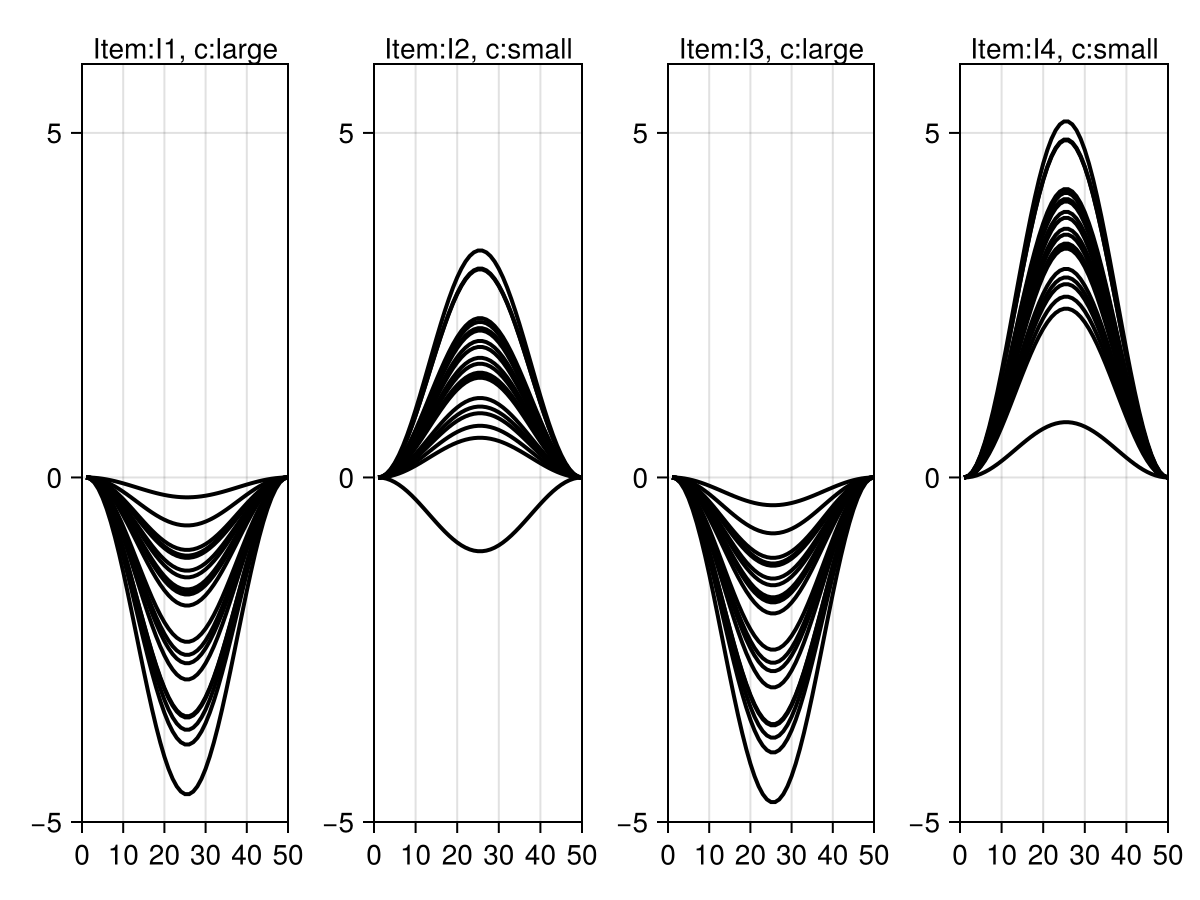

In [8]:
f = Figure()

for k = 1:4
    series(
        f[1, k],
        data[:, k, :]',
        solid_color = :black,
        axis = (; limits = ((0, 50), (-5, 6))),
    )
    Label(f[1, k, Top()], text = "Item:" * evts[k, :item] * ", c:" * evts[k, :condition])
end
f

In [9]:
data, evts = simulate(design, signal, UniformOnset(offset = 20, width = 50), NoNoise());
size(data)

┌ Warning: No random generator defined, used the default (`Random.MersenneTwister(1)`) with a fixed seed. This will always return the same results and the user is strongly encouraged to provide their own random generator!
└ @ UnfoldSim C:\Users\mvmigem\.julia\packages\UnfoldSim\1DN2P\src\simulation.jl:37


(303, 20)

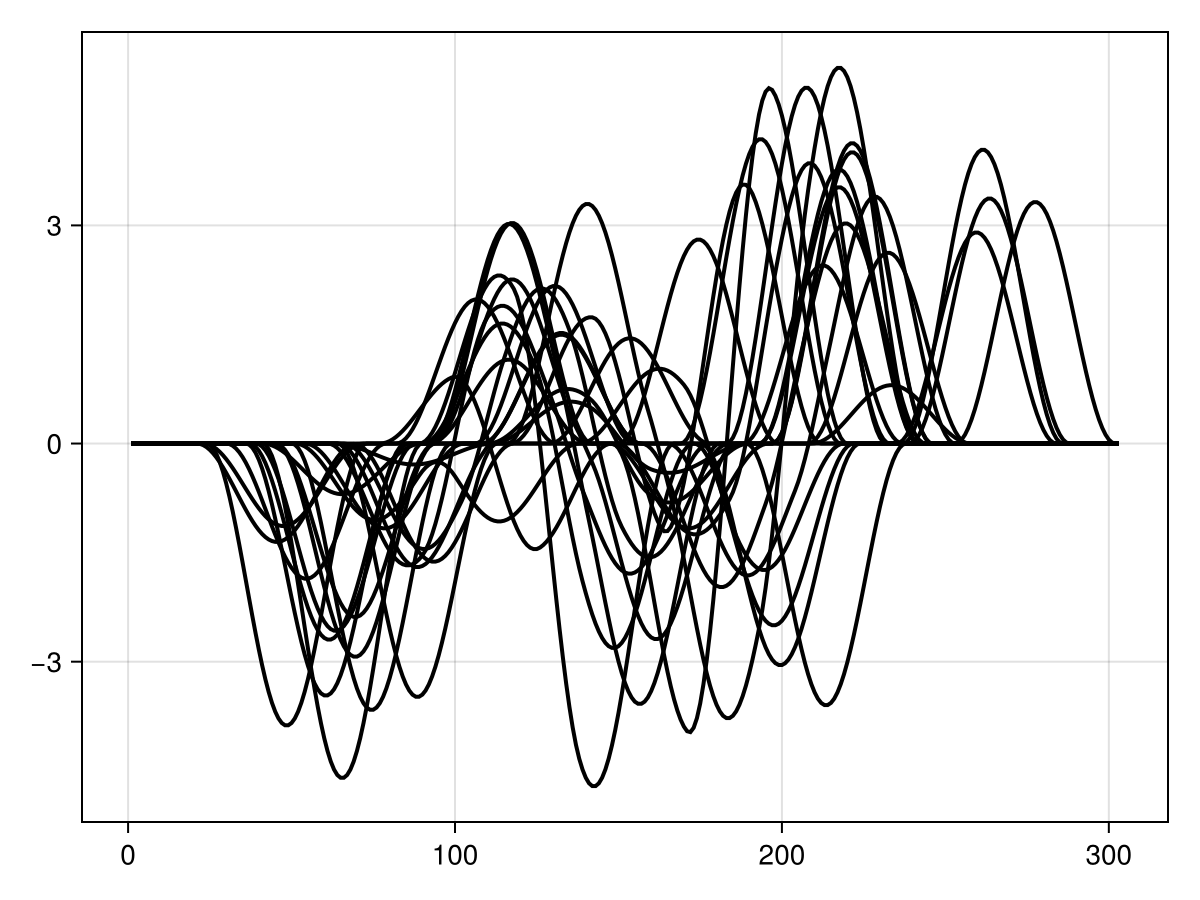

In [10]:
series(data', solid_color = :black)

In [11]:
data, evts = simulate(
    design,
    signal,
    UniformOnset(offset = 20, width = 50),
    NoNoise();
    return_epoched = true,
);
size(data)

┌ Warning: No random generator defined, used the default (`Random.MersenneTwister(1)`) with a fixed seed. This will always return the same results and the user is strongly encouraged to provide their own random generator!
└ @ UnfoldSim C:\Users\mvmigem\.julia\packages\UnfoldSim\1DN2P\src\simulation.jl:37


(50, 4, 20)

Minimizing 2    Time: 0:00:00 ( 0.26  s/it)
Minimizing 115    Time: 0:00:01 ( 9.86 ms/it)

Minimizing 116    Time: 0:00:01 ( 9.93 ms/it)
  objective:  158.6280801495108
Progress:   4%|██                                       |  ETA: 0:00:35

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  channel:  1
  time:     50


coefnames(f) = (Any[], ["(Intercept)", "condition: small", "(Intercept)", "(Intercept)", "condition: small"])
coefnames(f) = (Any[], ["(Intercept)", "condition: small", "(Intercept)", "(Intercept)", "condition: small"])
coefnames(f) = (Any[], ["(Intercept)", "condition: small", "(Intercept)", "(Intercept)", "condition: small"])


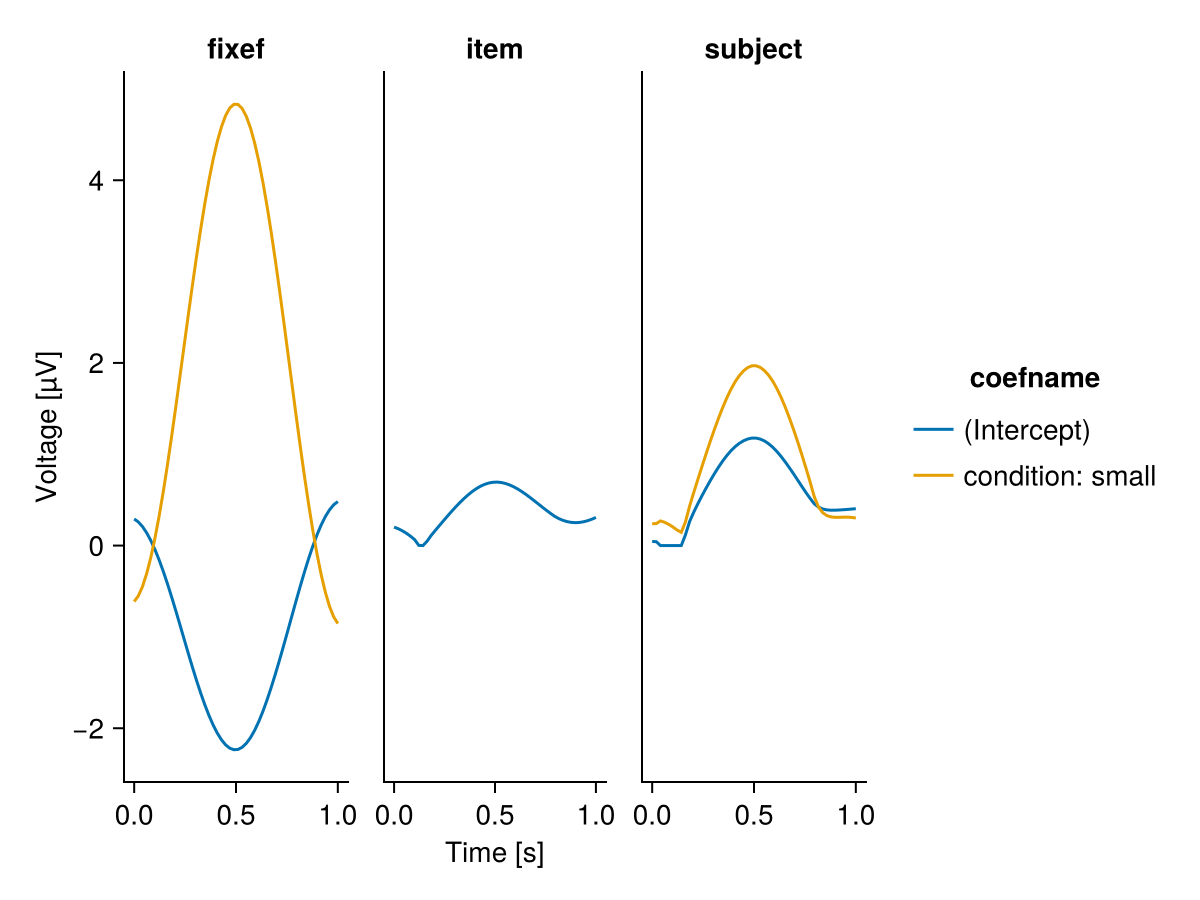

In [12]:
data = reshape(data, size(data, 1), :)
times = range(0, 1, length = size(data, 1))
m = fit(
    UnfoldModel,
    @formula(0 ~ 1 + condition + (1 | item) + (1 + condition | subject)),
    evts,
    data,
    times,
)
plot_erp(coeftable(m), mapping = (; col = :group))